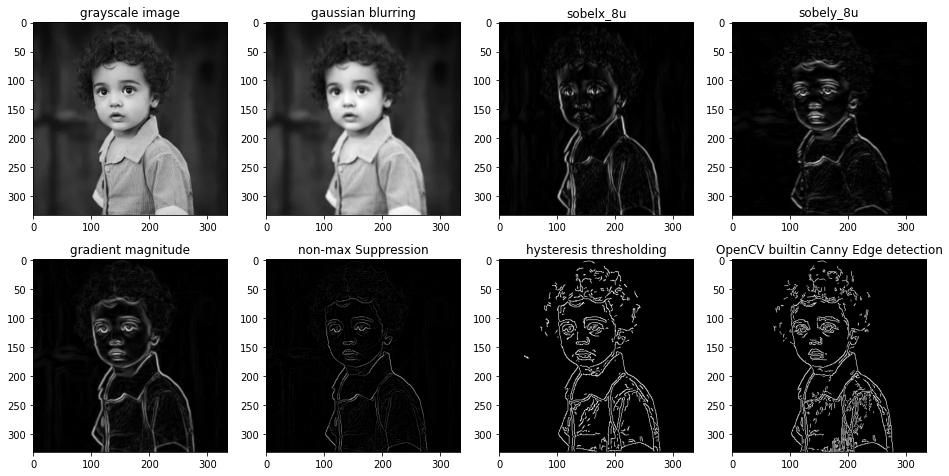

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
gray = cv2.imread('child.png', cv2.IMREAD_GRAYSCALE)

# 1. Noise Reduction
# Gaussian Blurring
blur = cv2.GaussianBlur(gray,(5,5),0)


# 2. Finding Intensity Gradient of the Image
# Apply Sobelx in high output datatype 'float32'
# and then converting back to 8-bit to prevent overflow
sobelx_32f = cv2.Sobel(blur,cv2.CV_32F,1,0,ksize=3)
absx_32f = np.absolute(sobelx_32f)
sobelx_8u1 = absx_32f/absx_32f.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# Similarly for Sobely
sobely_32f = cv2.Sobel(blur,cv2.CV_32F,0,1,ksize=3)
absy_32f = np.absolute(sobely_32f)
sobely_8u1 = absy_32f/absy_32f.max()*255
sobely_8u = np.uint8(sobely_8u1)
 
# From gradients calculate the magnitude and changing
# it to 8-bit (Optional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Find the direction and change it to degree
theta = np.arctan2(sobely_32f, sobelx_32f)
angle = np.rad2deg(theta)


# 3. Non-Max Suppression
# Find the neighbouring pixels (b,c) in the rounded gradient direction
# and then apply non-max suppression
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)
 
for i in range(1,M-1):
    for j in range(1,N-1):
        # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or \
           (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Non-max Suppression
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


# 4. Hysteresis Thresholding
# Set high and low threshold
highThreshold = 21
lowThreshold = 15
 
M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)
 
# If edge intensity is greater than 'High' it is a sure-edge
# below 'low' threshold, it is a sure non-edge
strong_i, strong_j = np.where(Non_max >= highThreshold)
zeros_i, zeros_j = np.where(Non_max < lowThreshold)
 
# weak edges
weak_i, weak_j = np.where((Non_max <= highThreshold) & (Non_max >= lowThreshold))
 
# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# For weak edges, if it is connected to a sure edge it will be considered as an edge otherwise suppressed.
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0


# Use OpenCV builtin function for performing Canny Edge detection
edges = cv2.Canny(gray,60,90,L2gradient=True)


plt.subplot(2,4,1)
plt.title("grayscale image")
plt.imshow(gray, cmap ='gray')

plt.subplot(2,4,2)
plt.title("gaussian blurring")
plt.imshow(blur, cmap ='gray')

plt.subplot(2,4,3)
plt.title("sobelx_8u")
plt.imshow(sobelx_8u, cmap ='gray')

plt.subplot(2,4,4)
plt.title("sobely_8u")
plt.imshow(sobely_8u, cmap ='gray')

plt.subplot(2,4,5)
plt.title("gradient magnitude")
plt.imshow(mag, cmap ='gray')

plt.subplot(2,4,6)
plt.title("non-max Suppression")
plt.imshow(Non_max, cmap ='gray')

plt.subplot(2,4,7)
plt.title("hysteresis thresholding")
plt.imshow(out, cmap ='gray')

plt.subplot(2,4,8)
plt.title("OpenCV builtin Canny Edge detection")
plt.imshow(edges, cmap ='gray')

plt.gcf().set_size_inches(16, 8)
plt.show()